# Pre - Processing

บางกรณีอาจทำการ Reasampling ก่อน

In [6]:
import numpy as np
import os
from scipy.fft import fft
from scipy.signal.windows import hamming
import matplotlib.pyplot as plt
import logging
from scipy.signal import find_peaks
import pandas as pd

In [7]:
# Parameters
fs = 128
nw = 256  # Window length of segment (2 seconds)
n2 = nw // 2  # 50% overlap (1 second)
win = hamming(nw)  # Windowing

logging.basicConfig(filename='ecg_processing.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

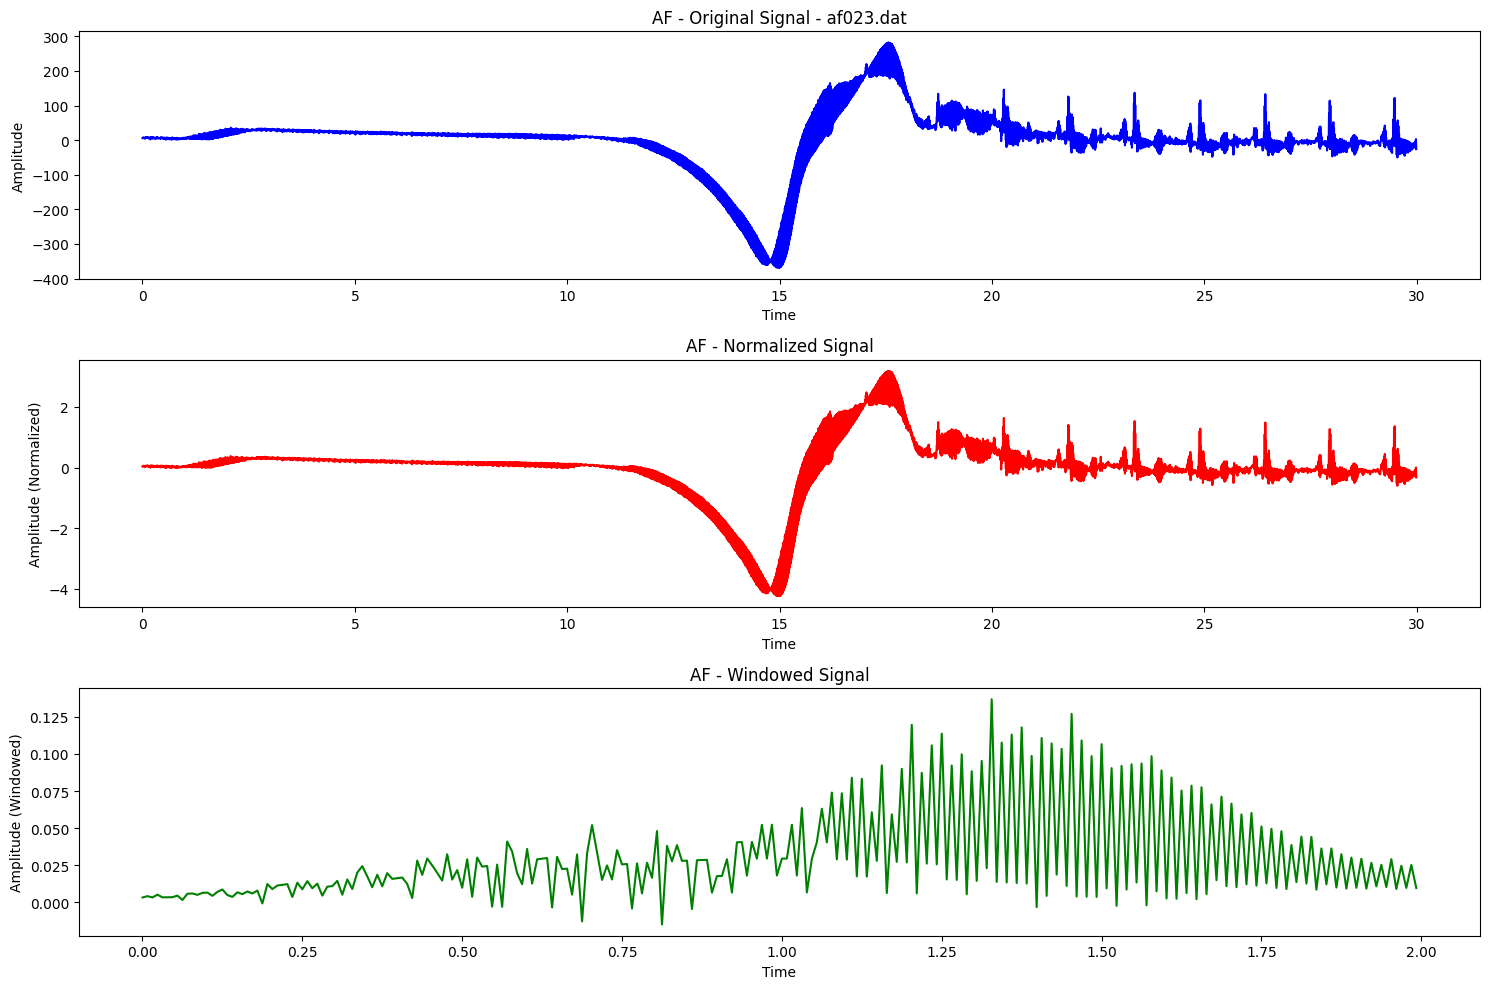

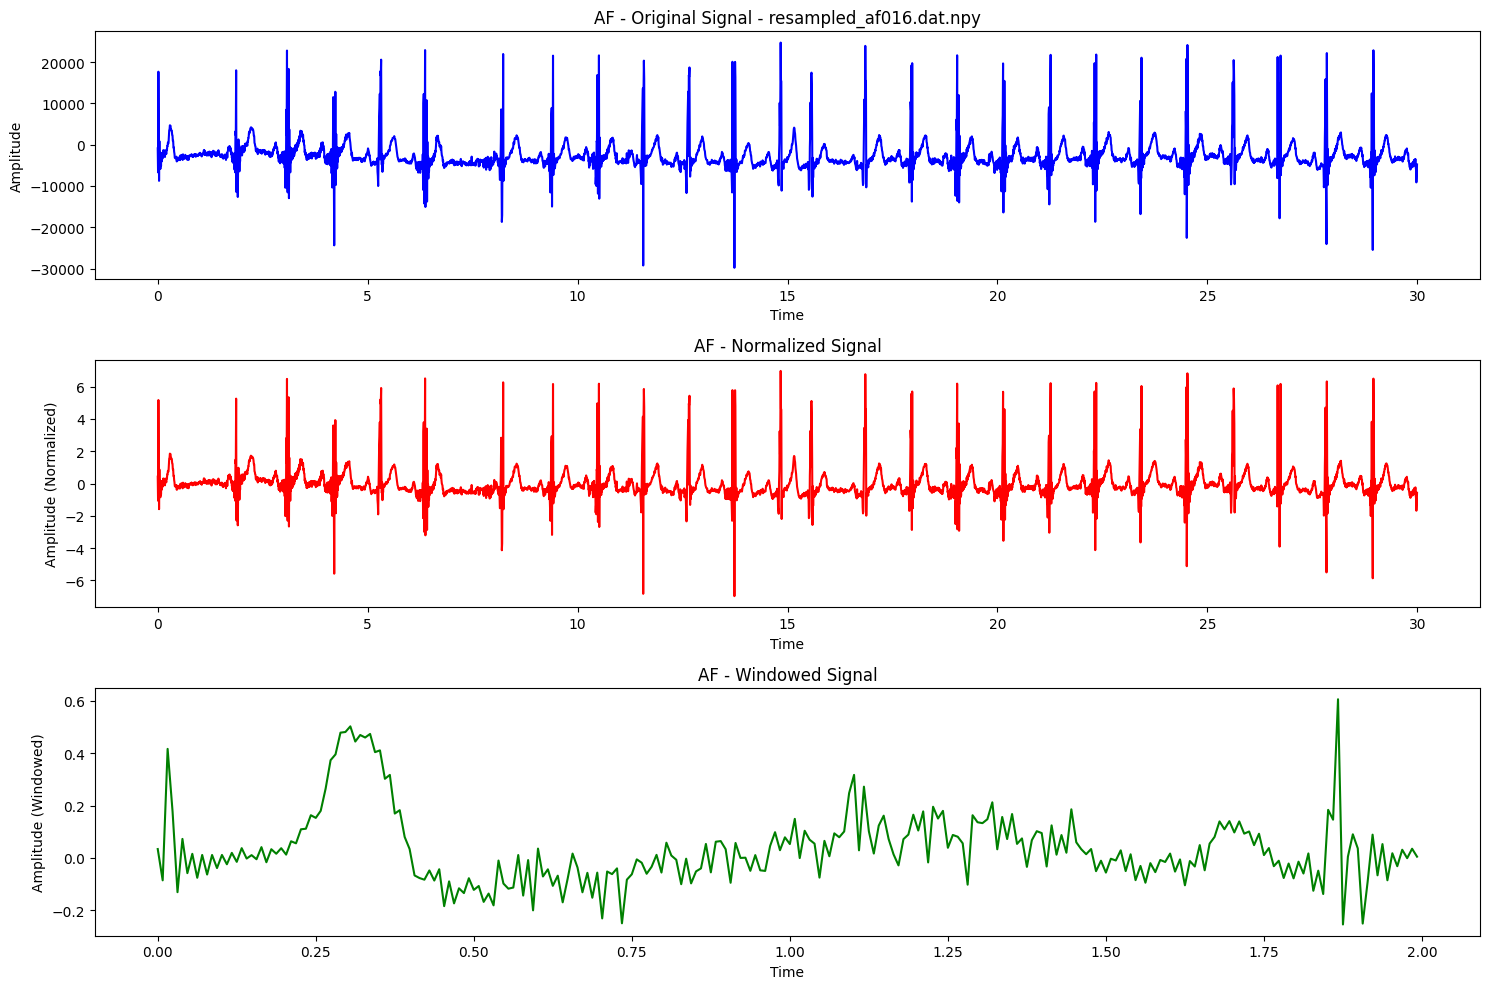

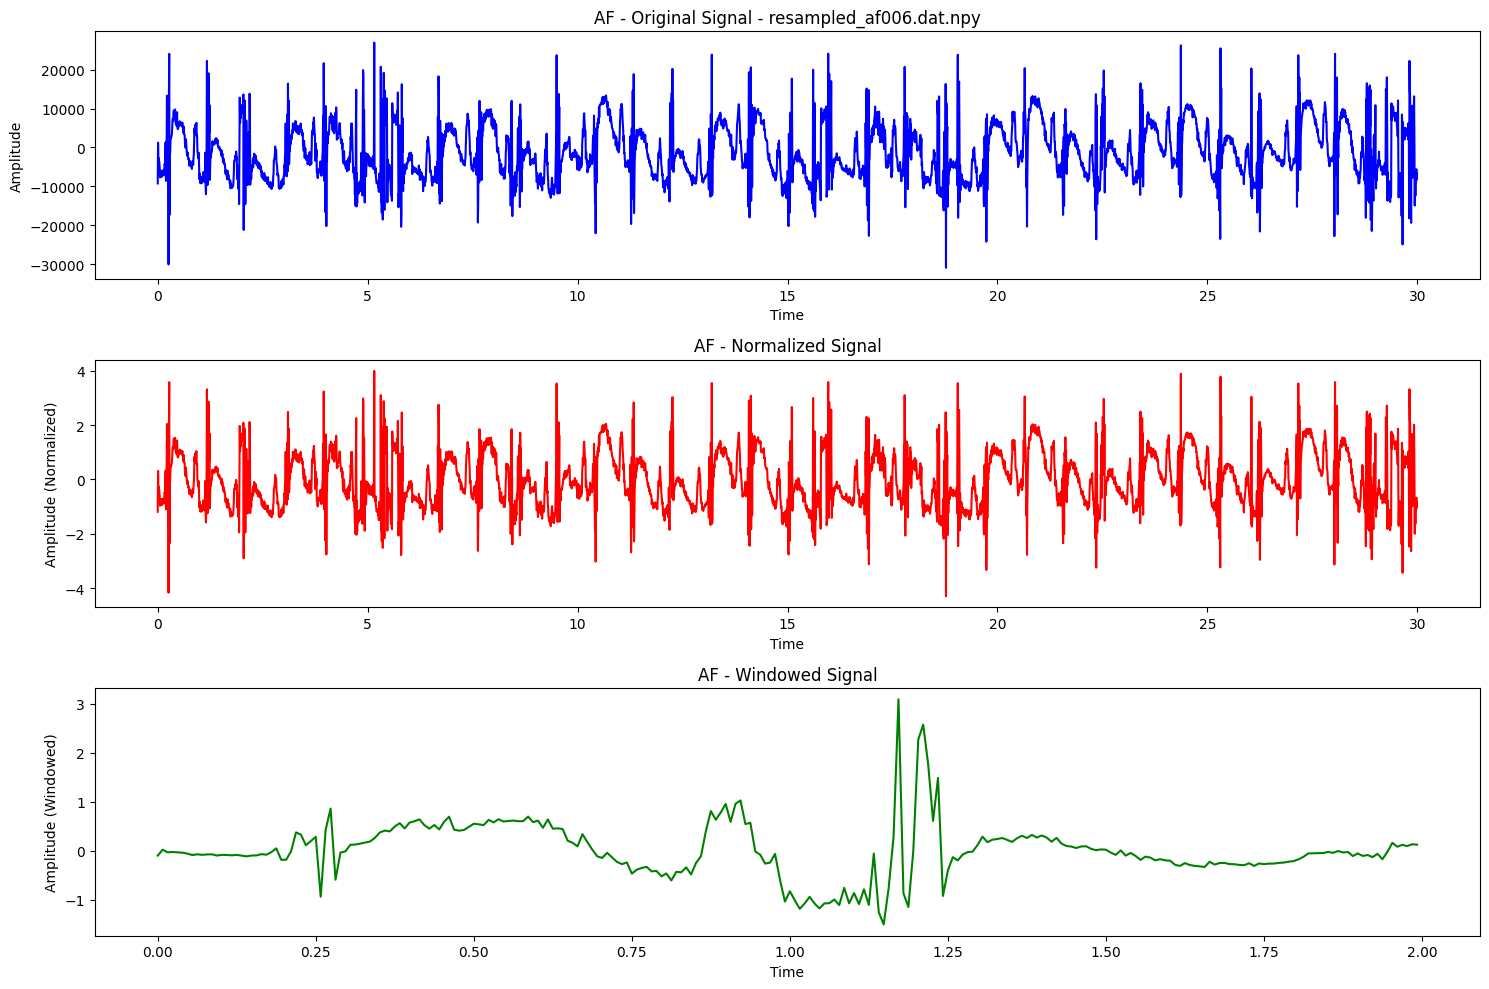

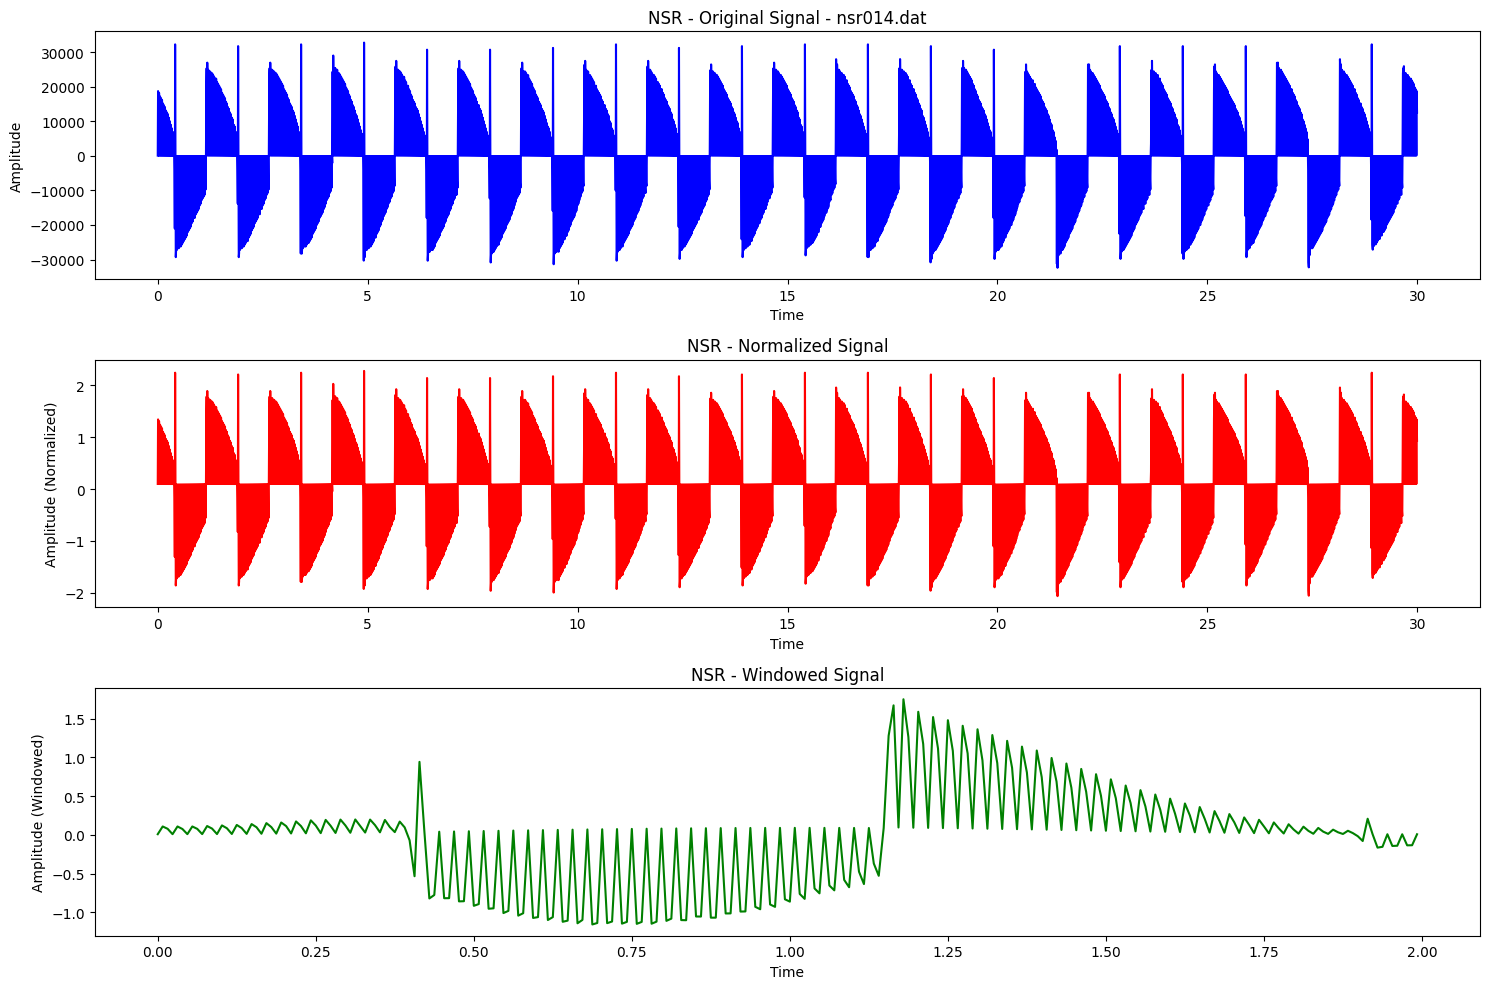

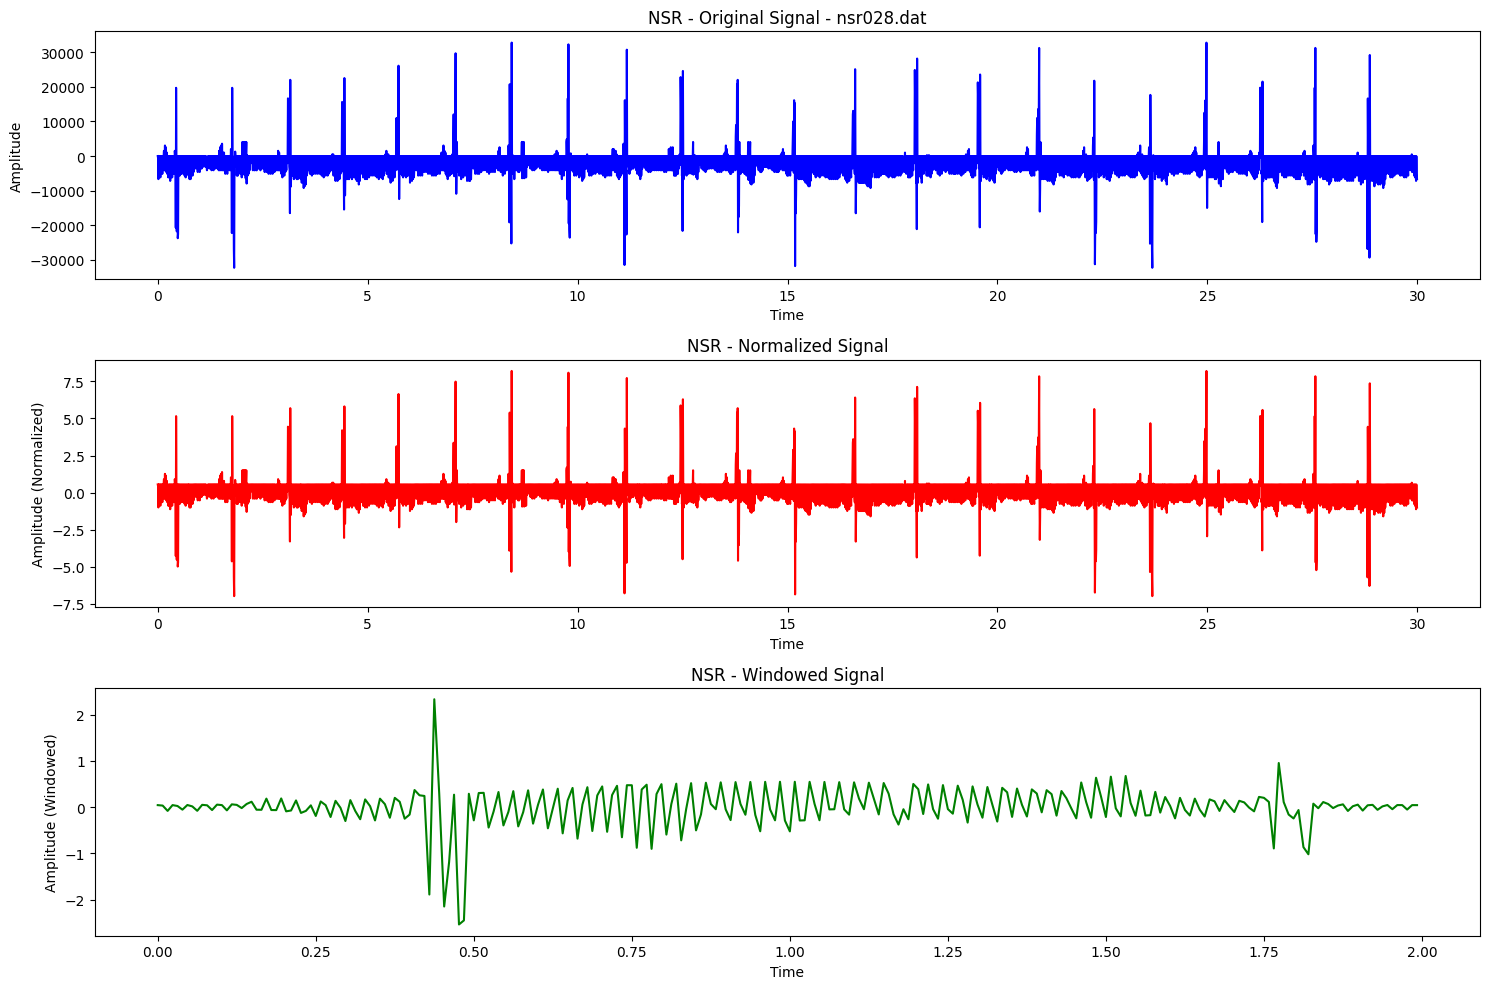

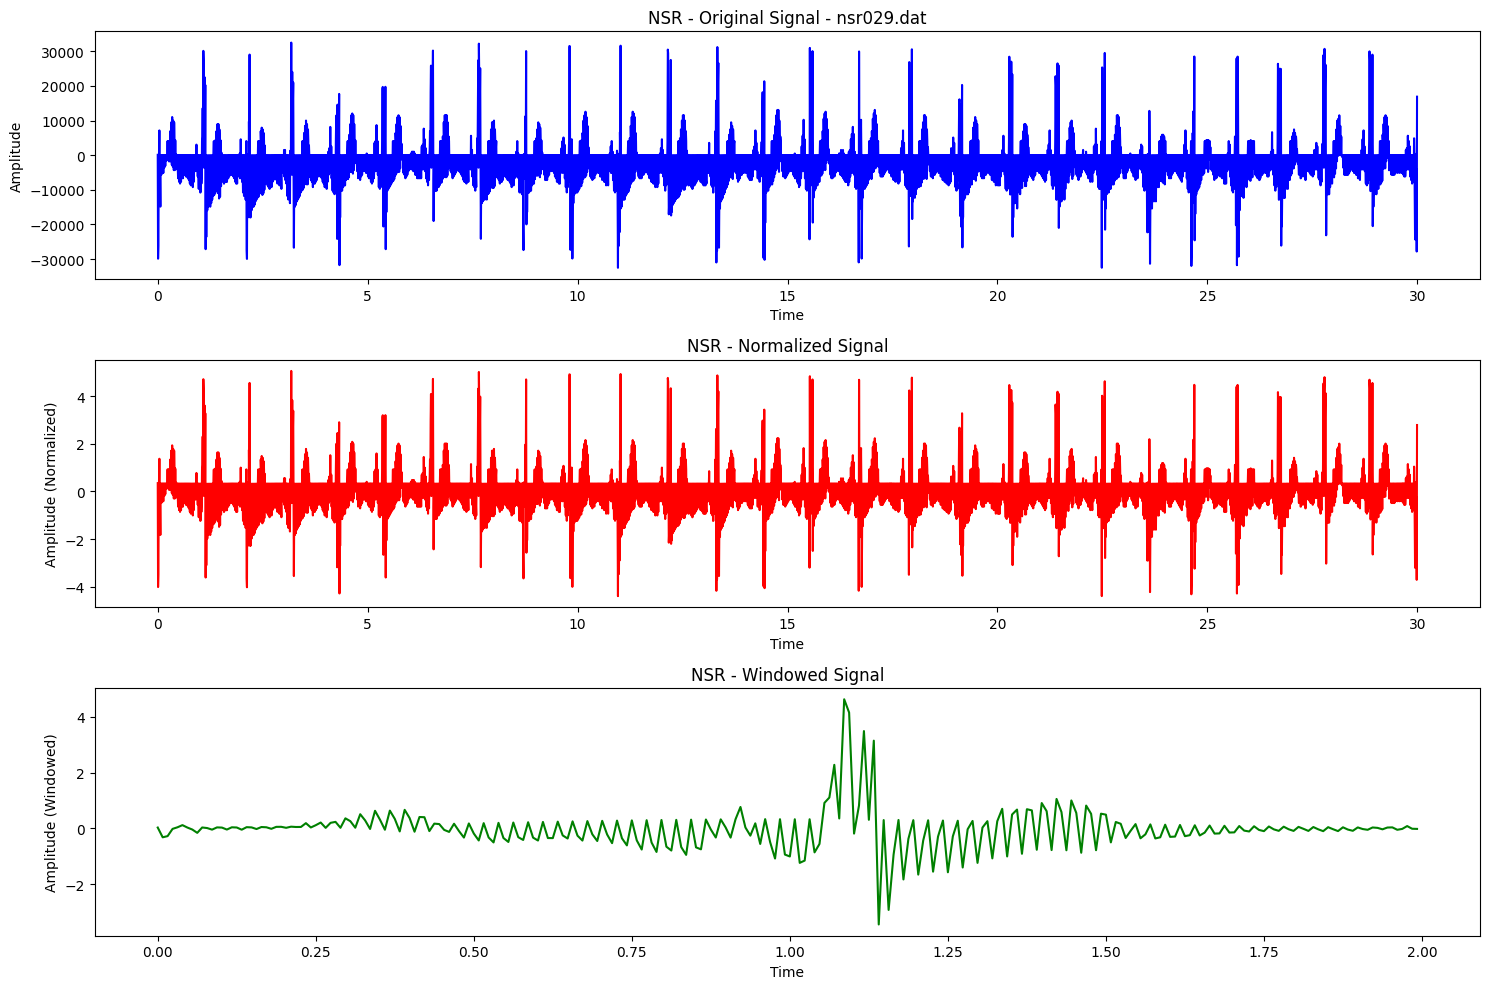

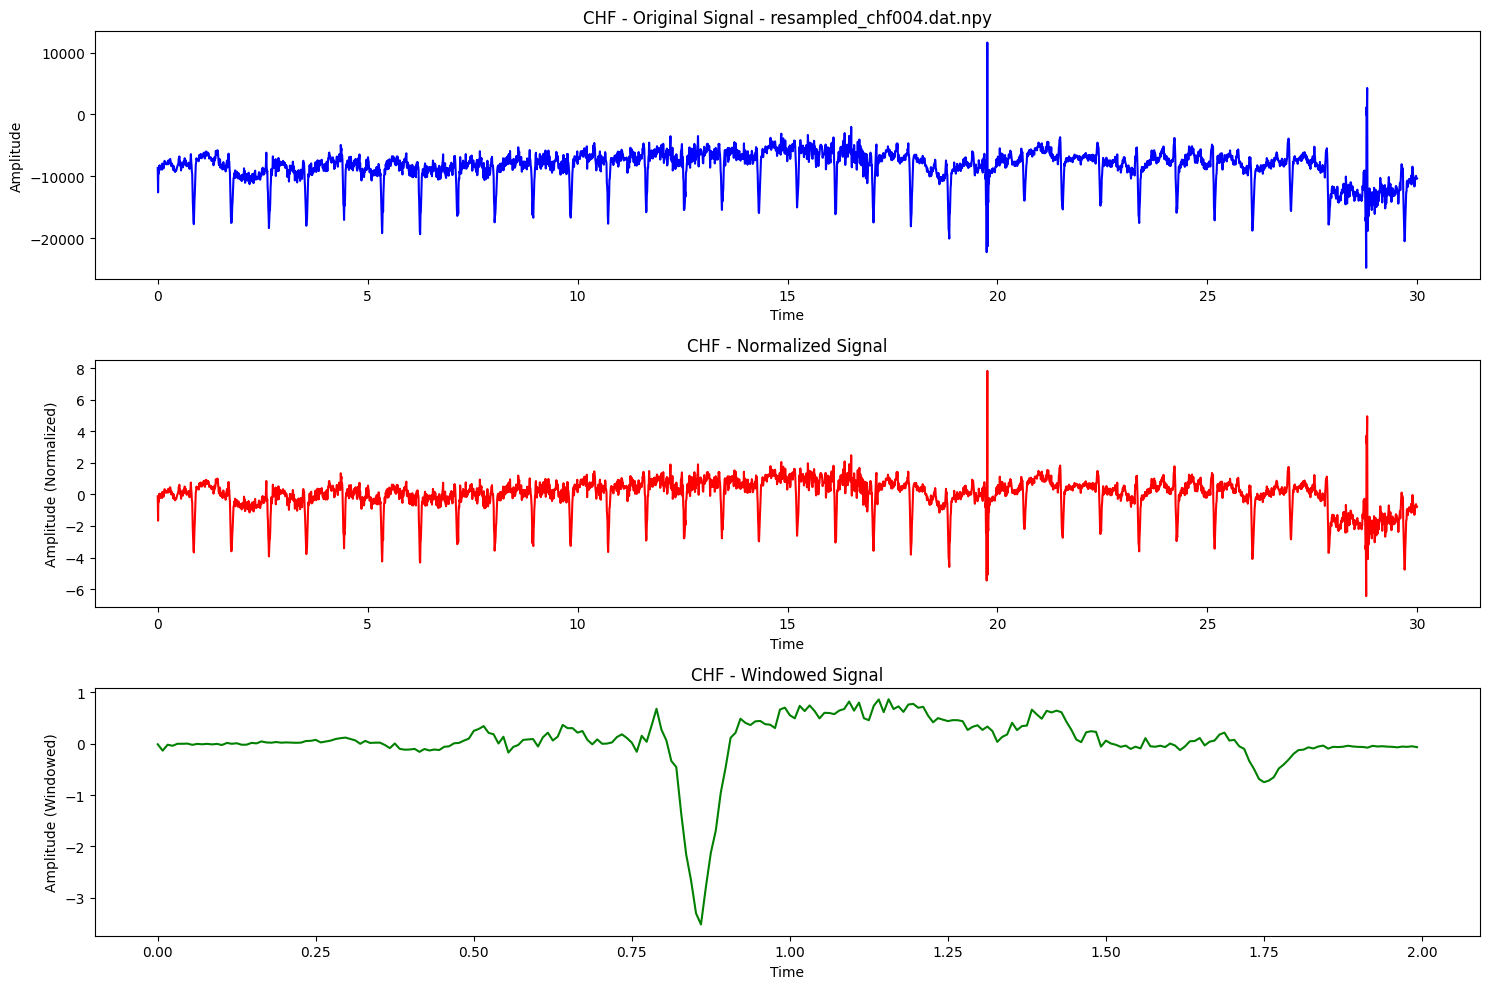

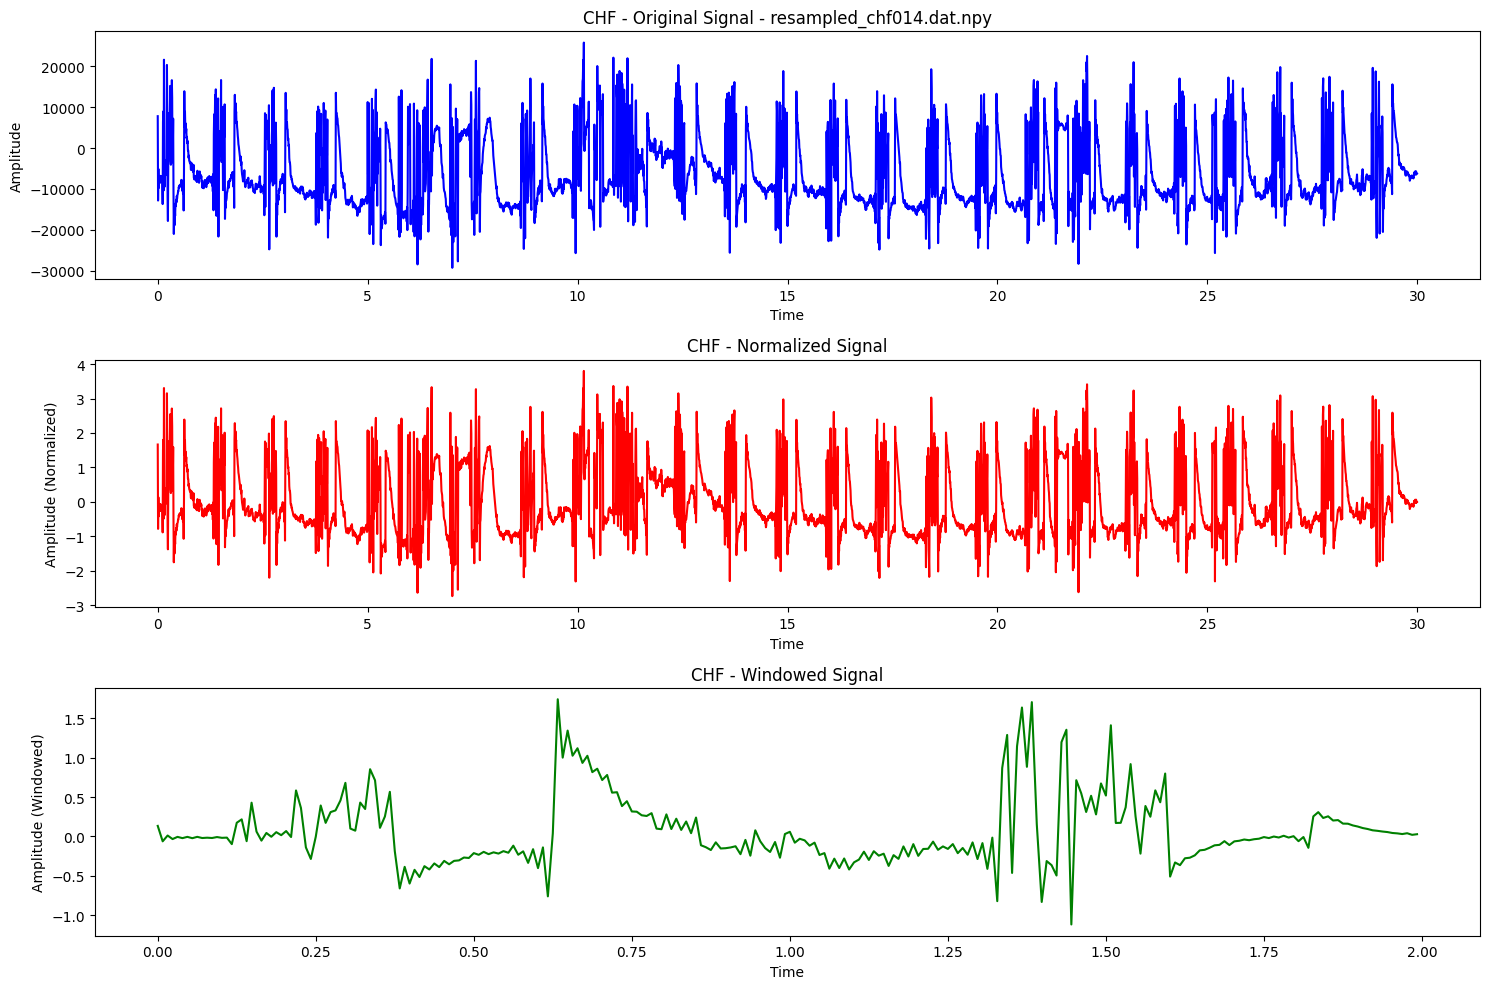

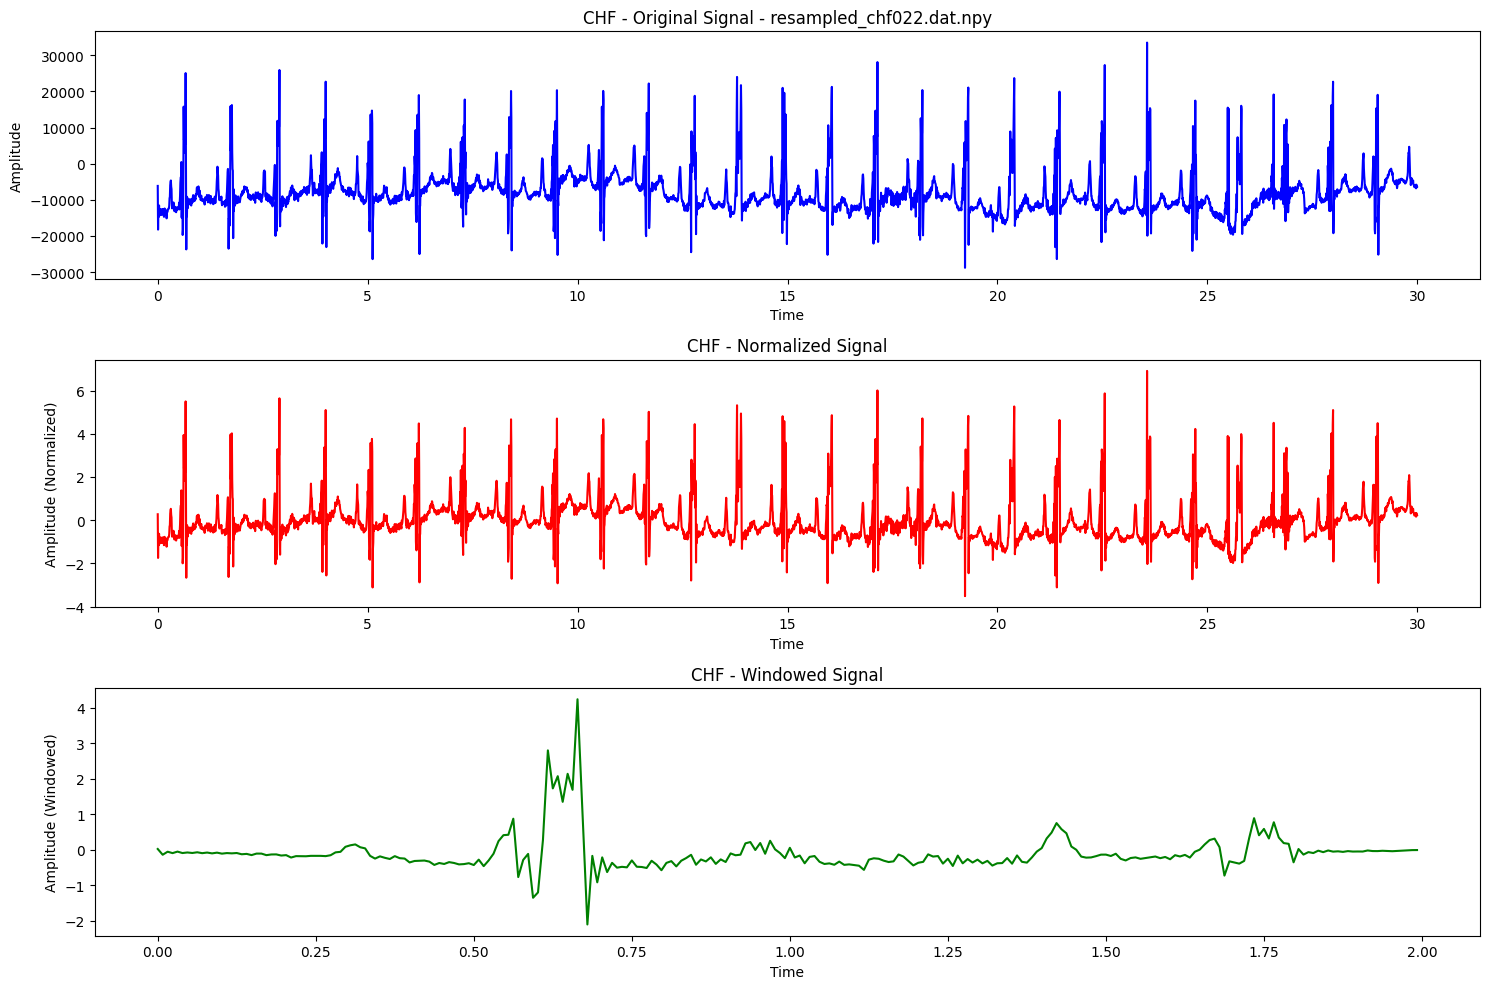

In [8]:
def plot_processing_stages(ecg_data, group_name, filename):
    """Plot ECG data at different processing stages."""
    try:
        # Calculate time windows
        max_samples = fs * 30   # 30 sec
        samples = fs * 2    # 2 sec
        
        # Limit data to 10 minutes if longer
        if len(ecg_data) > max_samples:
            ecg = ecg_data[:max_samples]
        else:
            ecg = ecg_data
            
        plt.figure(figsize=(15, 10))
        
        # 1. Original signal 
        plt.subplot(3, 1, 1)
        plt.plot(np.arange(len(ecg))/fs, ecg, 'b')
        plt.title(f"{group_name.upper()} - Original Signal - {filename}")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        
        # 2. Normalized signal 
        mean_val = np.mean(ecg)
        std_val = np.std(ecg)
        if std_val == 0:
            normalized_signal = ecg - mean_val
        else:
            normalized_signal = (ecg - mean_val) / std_val
            
        plt.subplot(3, 1, 2)
        plt.plot(np.arange(len(normalized_signal))/fs, normalized_signal, 'r')
        plt.title(f"{group_name.upper()} - Normalized Signal")
        plt.xlabel("Time")
        plt.ylabel("Amplitude (Normalized)")
        
        # 3. Windowed segment 
        signal = normalized_signal[:samples]
        windowed_signal = signal * hamming(len(signal))
        
        plt.subplot(3, 1, 3)
        plt.plot(np.arange(len(windowed_signal))/fs, windowed_signal, 'g')
        plt.title(f"{group_name.upper()} - Windowed Signal")
        plt.xlabel("Time")
        plt.ylabel("Amplitude (Windowed)")
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        logging.error(f"Error plotting processing stages for {filename}: {e}")

def clean_ecg(ecg):
    """Clean ECG data by removing or replacing invalid values."""
    ecg = ecg.astype(float)
    ecg[np.abs(ecg) > 1e6] = np.nan
    invalid_mask = np.isnan(ecg) | np.isinf(ecg)
    if np.any(invalid_mask):
        logging.warning(f"{np.sum(invalid_mask)} NaN or Inf values found in ECG data")
        valid_indices = np.where(~invalid_mask)[0]
        invalid_indices = np.where(invalid_mask)[0]
        if valid_indices.size > 0:
            ecg[invalid_indices] = np.interp(invalid_indices, valid_indices, ecg[valid_indices])
        else:
            logging.error("No valid data points found for interpolation")
            return None
    ecg = np.nan_to_num(ecg, nan=0.0, posinf=0.0, neginf=0.0)
    return ecg

def load_ecg_data(file_path):
    file_extension = os.path.splitext(file_path)[1].lower()
    data = None

    try:
        if file_extension == '.npy':
            data = np.load(file_path).astype(float)
        elif file_extension == '.dat':
            data = np.fromfile(file_path, dtype='<i2').astype(float)
            if np.isnan(data).any() or np.isinf(data).any():
                data = np.fromfile(file_path, dtype='<f4').astype(float)
        elif file_extension == '.csv':
            df = pd.read_csv(file_path, header=None, skiprows=2)
            df.columns = ['Elapsed time', 'ECG1']
            data = df['ECG1'].values
            logging.info(f"CSV file loaded: {file_path}, data shape: {data.shape}")
        
        if data is not None and len(data) > 0:
            logging.info(f"Data loaded successfully from {file_path}, shape: {data.shape}")
        else:
            logging.warning(f"No data loaded from {file_path}")
    except Exception as e:
        logging.error(f"Error loading file {file_path}: {e}")
        return None

    data = clean_ecg(data)
    return data

def detect_qrs(segment, fs):
    """Detect QRS complex in a segment."""
    segment = (segment - np.mean(segment)) / np.std(segment)
    peaks, _ = find_peaks(segment, height=1.5, distance=0.2*fs)
    return len(peaks) > 0

def segment_ecg(ecg, fs, nw, n2):
    max_samples = 10 * 60 * fs
    ecg = ecg[:max_samples]
    ecg = clean_ecg(ecg)
    if ecg is None:
        return None, None
    if len(ecg) < nw:
        logging.error(f"ECG data length ({len(ecg)}) is less than window length ({nw})")
        return None, None

    mean_val = np.mean(ecg)
    std_val = np.std(ecg)
    if not np.isfinite(mean_val) or not np.isfinite(std_val) or std_val == 0:
        logging.error("Invalid mean or std value for ECG data")
        return None, None
    ecg_normalized = (ecg - mean_val) / std_val

    Nc = len(ecg_normalized)
    t = np.arange(Nc) / fs
    ensemble = int(Nc / nw) + int(Nc / nw) - 1
    y = []
    mgSp = []
    e = 0
    valid_segments = 0

    while valid_segments < 5 and e < ensemble:
        n0 = e * n2
        if n0 + nw > Nc:
            break
        be = int(n0)
        en = int(n0 + nw)
        segment = ecg_normalized[be:en]

        if detect_qrs(segment, fs):
            wsp = segment * win
            spc = fs * fft(wsp)
            psd = np.abs(spc[:nw // 2])

            y.append(segment)
            mgSp.append(psd)
            valid_segments += 1
        else:
            logging.warning(f"Segment {e+1} does not contain a QRS complex. Skipping.")
        e += 1

    if valid_segments < 5:
        logging.warning(f"Only {valid_segments} valid segments found. This may affect analysis.")

    while e < ensemble:
        n0 = e * n2
        if n0 + nw > Nc:
            break
        be = int(n0)
        en = int(n0 + nw)
        segment = ecg_normalized[be:en]

        if detect_qrs(segment, fs):
            wsp = segment * win
            spc = fs * fft(wsp)
            psd = np.abs(spc[:nw // 2])

            y.append(segment)
            mgSp.append(psd)
        e += 1

    return np.array(y), np.array(mgSp)

def check_file_size(file_path, min_size=1024):
    if os.path.getsize(file_path) < min_size:
        logging.warning(f"File {file_path} is smaller than the expected size")
        return False
    return True

def process_files(file_paths, fs, nw, n2):
    all_y = []
    all_mgSp = []
    all_file_labels = []  # To store labels indicating the file each segment came from
    processed_files = 0
    
    for file_index, file_path in enumerate(file_paths):
        if not check_file_size(file_path):
            continue
        try:
            # Load and clean the data
            ecg = load_ecg_data(file_path)
            if ecg is None or len(ecg) == 0:
                continue
                
            # Plot processing stages for the first few files
            if file_index < 3:  # Plot only first 3 files
                plot_processing_stages(ecg, os.path.basename(os.path.dirname(file_path)), 
                                    os.path.basename(file_path))
            
            # Continue with segmentation and further processing
            y, mgSp = segment_ecg(ecg, fs, nw, n2)
            if y is None or mgSp is None:
                continue
            
            num_segments = len(y)
            logging.info(f"Processed file: {file_path}, y shape: {y.shape}, mgSp shape: {mgSp.shape}, Number of segments: {num_segments}")
            
            # Append data and labels
            all_y.append(y)
            all_mgSp.append(mgSp)
            
            # Create and append file-based labels as an additional column
            file_labels = np.array([os.path.basename(file_path)] * len(y))
            all_file_labels.append(file_labels)
            
            processed_files += 1

        except Exception as e:
            logging.error(f"Error processing file {file_path}: {e}")

    logging.info(f"Processed {processed_files} out of {len(file_paths)} files")

    if all_y and all_mgSp:
        all_y = np.concatenate(all_y, axis=0)
        all_mgSp = np.concatenate(all_mgSp, axis=0)
        all_file_labels = np.concatenate(all_file_labels, axis=0)
        
        # Ensure labels are strings
        all_file_labels = all_file_labels.astype(str)
        
        # Adding filename to the last column of both y and mgSp arrays
        all_y = np.hstack((all_y, all_file_labels[:, np.newaxis].astype(str)))
        all_mgSp = np.hstack((all_mgSp, all_file_labels[:, np.newaxis].astype(str)))
        
        logging.info(f"Final shapes - all_y: {all_y.shape}, all_mgSp: {all_mgSp.shape}")
    else:
        all_y = np.array([])
        all_mgSp = np.array([])
        logging.warning("No data processed successfully")

    return all_y, all_mgSp

directories = {
    'af': '/Users/khim/Downloads/ready_for_running/Dataset/raw data/AF',
    'nsr': '/Users/khim/Downloads/ready_for_running/Dataset/raw data/NSR',
    'chf': '/Users/khim/Downloads/ready_for_running/Dataset/raw data/CHF'
}

for group, dir_path in directories.items():
    file_paths = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith(('.npy', '.dat', '.csv'))]
    logging.info(f"Processing group: {group}")
    logging.info(f"Found {len(file_paths)} files")

    if len(file_paths) == 0:
        logging.warning(f"No files found for group {group}")
        continue

    all_y, all_mgSp = process_files(file_paths, fs, nw, n2)

    if len(all_y) > 0 and len(all_mgSp) > 0:
        logging.info(f"Group {group}: all_y shape: {all_y.shape}")
        logging.info(f"Group {group}: all_mgSp shape: {all_mgSp.shape}")
        np.save(f"/Users/khim/Downloads/ready_for_running/Dataset/prep data/{group}_all_segments_.npy", all_y)
        np.save(f"/Users/khim/Downloads/ready_for_running/Dataset/prep data/{group}_all_psd_.npy", all_mgSp)
    else:
        logging.warning(f"Group {group} produced no valid data")

logging.info("Processing completed.")

## Labeling

In [9]:
import numpy as np
import pandas as pd

def load_mixed_data(file_path):
    """Load numpy file with mixed data types (floats and strings)."""
    data = np.load(file_path, allow_pickle=True)
    
    # Inspect data type and content
    print(f"Data loaded from {file_path}:")
    print(f"Data shape: {data.shape}")
    print(f"Data type: {data.dtype}")
    print(f"Sample data: {data[:5]}")  # Print the first 5 rows for inspection

    if data.ndim == 1 and isinstance(data[0], (list, np.ndarray)):
        data = np.array(data)
    
    if data.ndim == 2:
        num_rows, num_cols = data.shape
        filenames = data[:, -1]  # Extract the last column (filenames)
        numeric_data = data[:, :-1]  # Extract all other columns
        
        # Convert all data to numeric, coercing errors to NaN
        numeric_data = np.apply_along_axis(lambda x: pd.to_numeric(x, errors='coerce'), 1, numeric_data)

        # Convert filenames to string if they are not already
        filenames = filenames.astype(str)
        
        return numeric_data, filenames
    else:
        raise ValueError("Unexpected data shape or format")

def create_labels_from_filenames(filenames):
    """Extract labels from filenames."""
    labels = []
    for filename in filenames:
        if 'af' in filename:
            labels.append('af')
        elif 'nsr' in filename:
            labels.append('nsr')
        elif 'chf' in filename:
            labels.append('chf')
        else:
            raise ValueError(f"Unknown label in filename: {filename}")
    return labels

# Paths to your files
file_paths = [
    '/Users/khim/Downloads/ready_for_running/Dataset/prep data/nsr_all_segments_.npy',
    '/Users/khim/Downloads/ready_for_running/Dataset/prep data/af_all_segments_.npy',
    '/Users/khim/Downloads/ready_for_running/Dataset/prep data/chf_all_segments_.npy'
]

# Initialize empty lists to hold the combined data and labels
all_data = []
all_labels = []

# Load data from each file and concatenate
for file_path in file_paths:
    data, filenames = load_mixed_data(file_path)
    labels = create_labels_from_filenames(filenames)
    
    all_data.append(data)
    all_labels.extend(labels)

# Convert lists to numpy arrays
X = np.vstack(all_data)
y = np.array(all_labels)

# Map labels to numeric values
label_map = {'af': 1, 'nsr': 0, 'chf': 2}
y_numeric = np.array([label_map[label] for label in y])

# Create DataFrames for saving
df_X = pd.DataFrame(X)
df_y = pd.DataFrame(y_numeric, columns=['Label'])

# Save DataFrames to CSV
df_X.to_csv('/Users/khim/Downloads/ready_for_running/Dataset/prep data/lebeled/x_segment.csv', index=False)
df_y.to_csv('/Users/khim/Downloads/ready_for_running/Dataset/prep data/lebeled/y_segment.csv', index=False)

print("Data saved to x_segment.csv and y_segment.csv successfully.")

Data loaded from /Users/khim/Downloads/ready_for_running/Dataset/prep data/nsr_all_segments_.npy:
Data shape: (17960, 257)
Data type: <U32
Sample data: [['0.3110865014498089' '2.9945237750763685' '2.177731707380672' ...
  '-3.527448021229247' '0.28549435428384623' 'nsr014.dat']
 ['-1.7607272101317772' '0.29297071188289153' '-1.5479385707743347' ...
  '3.2159389808942476' '2.177731707380672' 'nsr014.dat']
 ['-3.542400736427337' '-3.527448021229247' '0.28578190649919416' ...
  '0.2923956074521957' '-1.695165305032457' 'nsr014.dat']
 ['0.31166160588050473' '3.0681371422054298' '2.177731707380672' ...
  '-3.4538346541001856' '0.28520680206849836' 'nsr014.dat']
 ['-1.687113843002716' '0.29297071188289153' '-1.5473634663436389' ...
  '3.0687122466361254' '2.177731707380672' 'nsr014.dat']]
Data loaded from /Users/khim/Downloads/ready_for_running/Dataset/prep data/af_all_segments_.npy:
Data shape: (17191, 257)
Data type: <U32
Sample data: [['0.20738561185477458' '0.24171335578590597' '0.207385

In [10]:
import numpy as np
import pandas as pd

def load_mixed_data(file_path):
    """Load numpy file with mixed data types (floats and strings)."""
    data = np.load(file_path, allow_pickle=True)
    
    # Inspect data type and content
    print(f"Data loaded from {file_path}:")
    print(f"Data shape: {data.shape}")
    print(f"Data type: {data.dtype}")
    print(f"Sample data: {data[:5]}")  # Print the first 5 rows for inspection

    if data.ndim == 1 and isinstance(data[0], (list, np.ndarray)):
        data = np.array(data)
    
    if data.ndim == 2:
        num_rows, num_cols = data.shape
        filenames = data[:, -1]  # Extract the last column (filenames)
        numeric_data = data[:, :-1]  # Extract all other columns
        
        # Convert all data to numeric, coercing errors to NaN
        numeric_data = np.apply_along_axis(lambda x: pd.to_numeric(x, errors='coerce'), 1, numeric_data)

        # Convert filenames to string if they are not already
        filenames = filenames.astype(str)
        
        return numeric_data, filenames
    else:
        raise ValueError("Unexpected data shape or format")

def create_labels_from_filenames(filenames):
    """Extract labels from filenames."""
    labels = []
    for filename in filenames:
        if 'af' in filename:
            labels.append('af')
        elif 'nsr' in filename:
            labels.append('nsr')
        elif 'chf' in filename:
            labels.append('chf')
        else:
            raise ValueError(f"Unknown label in filename: {filename}")
    return labels

# Paths to your files
file_paths = [
    '/Users/khim/Downloads/ready_for_running/Dataset/prep data/nsr_all_psd_.npy',
    '/Users/khim/Downloads/ready_for_running/Dataset/prep data/af_all_psd_.npy',
    '/Users/khim/Downloads/ready_for_running/Dataset/prep data/chf_all_psd_.npy'
]

# Initialize empty lists to hold the combined data and labels
all_data = []
all_labels = []

# Load data from each file and concatenate
for file_path in file_paths:
    data, filenames = load_mixed_data(file_path)
    labels = create_labels_from_filenames(filenames)
    
    all_data.append(data)
    all_labels.extend(labels)

# Convert lists to numpy arrays
X_train = np.vstack(all_data)
y_train = np.array(all_labels)

# Map labels to numeric values
label_map = {'af': 1, 'nsr': 0, 'chf': 2}
y_train_numeric = np.array([label_map[label] for label in y_train])

# Create DataFrames for saving
df_X = pd.DataFrame(X_train)
df_y = pd.DataFrame(y_train_numeric, columns=['Label'])

# Save DataFrames to CSV
df_X.to_csv('/Users/khim/Downloads/ready_for_running/Dataset/prep data/lebeled/psd_data.csv', index=False)
df_y.to_csv('/Users/khim/Downloads/ready_for_running/Dataset/prep data/lebeled/psd_label.csv', index=False)

print("Data saved to psd_data.csv and psd_label.csv successfully.")

Data loaded from /Users/khim/Downloads/ready_for_running/Dataset/prep data/nsr_all_psd_.npy:
Data shape: (17960, 129)
Data type: <U32
Sample data: [['836.187092742586' '17972.538767240665' '14333.398470046095'
  '2662.7843627793363' '5643.90836215349' '3097.4327508000656'
  '1763.7663329118427' '3307.7198308050156' '1148.0381377796657'
  '1941.8021935787845' '1965.2863907949702' '912.245626956079'
  '1860.2177020417594' '1252.892157516758' '952.665082829212'
  '1350.6296345434764' '1103.5225726362335' '956.5642167361317'
  '1135.507533727423' '887.0543157723032' '754.995516360005'
  '1073.0153682099588' '556.0781156508812' '780.3153877664682'
  '981.3393586631571' '378.41941262505435' '889.9976198866824'
  '713.190120838792' '396.11968333800326' '856.9898218316649'
  '520.7190175462432' '502.67548401937245' '828.0070476376978'
  '381.40785864079174' '577.7031468709073' '799.2481289700954'
  '149.54287555802097' '722.1333320427952' '628.2018494918997'
  '156.31216357721038' '889.0563220

# Features Extraction

In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder


## Time Domain

### QRS complex

In [12]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
from scipy import stats
import os
import matplotlib.pyplot as plt

# Load signal data and labels
x_data = pd.read_csv('/Users/khim/Downloads/ready_for_running/Dataset/prep data/lebeled/x_segment.csv')  
y_labels = pd.read_csv('/Users/khim/Downloads/ready_for_running/Dataset/prep data/lebeled/y_segment.csv')  

In [17]:
def check_segments_connectivity(seg1, seg2, overlap_threshold=0.9):
    """
    ตรวจสอบว่า segments สามารถเชื่อมต่อกันได้หรือไม่
    โดยดูจากความคล้ายคลึงของข้อมูลที่ซ้อนทับกัน
    
    Parameters:
    seg1, seg2: numpy arrays ของ segments ที่จะตรวจสอบ
    overlap_threshold: ค่าความคล้ายคลึงขั้นต่ำที่ยอมรับได้ (0-1)
    
    Returns:
    bool: True ถ้าสามารถเชื่อมต่อได้
    """
    # ตรวจสอบส่วนท้ายของ seg1 กับส่วนต้นของ seg2
    overlap_size = len(seg1) // 4  # สมมติว่า overlap 25%
    seg1_end = seg1[-overlap_size:]
    seg2_start = seg2[:overlap_size]
    
    # คำนวณความคล้ายคลึง (correlation)
    correlation = np.corrcoef(seg1_end, seg2_start)[0, 1]
    return correlation > overlap_threshold

def connect_segments(seg1, seg2):
    """
    เชื่อมต่อ segments โดยใช้ส่วนที่ซ้อนทับกัน
    """
    overlap_size = len(seg1) // 4
    # ตัดส่วนที่ซ้อนทับออกจาก seg1 แล้วต่อกับ seg2
    return np.concatenate([seg1[:-overlap_size], seg2])

def detect_r_peaks(ecg_signal, distance, height):
    # Find R-peaks using find_peaks
    peaks, _ = find_peaks(ecg_signal, distance=distance, height=height)
    return peaks

def calculate_qrs_duration(ecg_signal, r_peaks, sample_rate):
    if not r_peaks.size:
        return 0  # หรือค่า NaN ถ้าไม่พบ R-peak
    
    r_peak = r_peaks[len(r_peaks) // 2]  # เลือก R-peak ตรงกลาง
    q_point = np.argmin(ecg_signal[max(0, r_peak-30):r_peak]) + (r_peak-30)
    s_point = np.argmin(ecg_signal[r_peak:min(len(ecg_signal), r_peak+30)]) + r_peak
    qrs_duration = (s_point - q_point) / sample_rate
    return qrs_duration

def detect_p_t_waves(ecg_signal, r_peaks):
    if not r_peaks.size:
        return 0, 0  # หรือค่า NaN ถ้าไม่พบ R-peak
    
    r_peak = r_peaks[len(r_peaks) // 2]  # เลือก R-peak ตรงกลาง
    p_wave = np.argmax(ecg_signal[max(0, r_peak-50):r_peak]) + (r_peak-50)
    t_wave = np.argmax(ecg_signal[r_peak:min(len(ecg_signal), r_peak+50)]) + r_peak
    return p_wave, t_wave

def calculate_intervals(r_peak, p_wave, t_wave, qrs_duration, sample_rate):
    pr_interval = (r_peak - p_wave) / sample_rate
    st_interval = (t_wave - r_peak) / sample_rate
    return pr_interval, st_interval

def calculate_rr_interval(connected_signal, sample_rate):
    """
    คำนวณ RR interval จากสัญญาณที่เชื่อมต่อกันแล้ว
    """
    r_peaks = detect_r_peaks(connected_signal, distance=sample_rate//2, height=0.5)
    if len(r_peaks) < 2:
        return 0
    
    # คำนวณค่าเฉลี่ย RR interval
    rr_intervals = np.diff(r_peaks) / sample_rate
    return np.mean(rr_intervals)

def calculate_skewness_kurtosis(ecg_signal, r_peak):
    qrs_window = ecg_signal[max(0, r_peak-30):min(len(ecg_signal), r_peak+30)]
    return skew(qrs_window), kurtosis(qrs_window)

sample_rate = 128  # Sampling rate in Hz

def extract_features(segment, next_segment=None, sample_rate=128):
    """
    สกัดฟีเจอร์รวมถึง RR interval ถ้ามี segment ถัดไป
    """
    r_peaks = detect_r_peaks(segment, distance=sample_rate//2, height=0.5)
    
    if not r_peaks.size:
        return [0] * 6  # หรือ return ค่า NaN ถ้าไม่พบ R-peak ( 6 features )
    
    qrs_duration = calculate_qrs_duration(segment, r_peaks, sample_rate)
    p_wave, t_wave = detect_p_t_waves(segment, r_peaks)
    r_peak = r_peaks[len(r_peaks) // 2]  # เลือก R-peak ตรงกลาง
    pr_interval, st_interval = calculate_intervals(r_peak, p_wave, t_wave, qrs_duration, sample_rate)
    qrs_skewness, qrs_kurtosis = calculate_skewness_kurtosis(segment, r_peak)

    # คำนวณ RR interval ถ้ามี segment ถัดไป
    rr_interval = 0
    if next_segment is not None and check_segments_connectivity(segment, next_segment):
        connected_signal = connect_segments(segment, next_segment)
        rr_interval = calculate_rr_interval(connected_signal, sample_rate)
    
    return [qrs_duration, pr_interval, st_interval, qrs_skewness, qrs_kurtosis, rr_interval]

# สกัดฟีเจอร์สำหรับทุก segment
features = []
segments = x_data.values
labels = y_labels['Label'].values

for i in range(len(segments)):
    next_segment = None
    if i < len(segments) - 1 and labels[i] == labels[i + 1]:
        next_segment = segments[i + 1]
    
    features.append([labels[i]] + extract_features(segments[i], next_segment))

# Create DataFrame with labels in the first column
columns = ['Label', 'QRS_Duration', 'PR_Interval', 'ST_Interval', 
          'QRS_Skewness', 'QRS_Kurtosis', 'RR_Interval']
features_df = pd.DataFrame(features, columns=columns)

# Save to file
output_path = '/Users/khim/Downloads/ready_for_running/Dataset/features/nsr_af_chf_06.csv'
features_df.to_csv(output_path, index=False)

In [19]:
# โหลดข้อมูล
x_segment = pd.read_csv('/Users/khim/Downloads/ready_for_running/Dataset/prep data/lebeled/x_segment.csv')
y_label = pd.read_csv('/Users/khim/Downloads/ready_for_running/Dataset/prep data/lebeled/y_segment.csv')

# คำนวณคุณสมบัติ (features)
def calculate_features(data):
    features = pd.DataFrame()
    features['variance'] = np.var(data, axis=1)
    features['skewness'] = skew(data, axis=1, nan_policy='omit')
    features['kurtosis'] = kurtosis(data, axis=1, nan_policy='omit')
    return features

# คำนวณคุณสมบัติ
x_segment_features = calculate_features(x_segment)

# เส้นทางของไฟล์ใหม่ที่จะบันทึก
new_file = '/Users/khim/Downloads/ready_for_running/Dataset/features/nsr_af_chf_09.csv'

existing_file = '/Users/khim/Downloads/ready_for_running/Dataset/features/nsr_af_chf_06.csv'
existing_df = pd.read_csv(existing_file)

# รวมข้อมูลใหม่กับไฟล์ที่มีอยู่แล้ว
combined_df = pd.concat([existing_df, x_segment_features[['variance', 'skewness', 'kurtosis']]], axis=1)

# บันทึกข้อมูลที่รวมใหม่ลงในไฟล์ใหม่
combined_df.to_csv(new_file, index=False)

## Frequency Domain

In [20]:
psd_data = pd.read_csv('/Users/khim/Downloads/ready_for_running/Dataset/prep data/lebeled/psd_data.csv')
psd_labels = pd.read_csv('/Users/khim/Downloads/ready_for_running/Dataset/prep data/lebeled/psd_label.csv')

# ช่วงความถี่ที่กำหนด
bands = [(0, 3), (3, 6), (6, 9)]

# คำนวณพลังงานรวมในช่วงความถี่
def calculate_band_power(df, bands):
    band_power = {}
    num_cols = df.shape[1]
    freq_step = 0.5  # ความละเอียดของความถี่ (Hz)
    for band in bands:
        freq_min, freq_max = band
        # คำนวณช่วงคอลัมน์ที่ตรงกับช่วงความถี่
        col_min = int(freq_min / freq_step)
        col_max = int(freq_max / freq_step)
        # คำนวณพลังงานรวมในช่วงความถี่
        band_label = f"{freq_min}_{freq_max}"
        band_power[band_label] = df.iloc[:, col_min:col_max].sum(axis=1)
    return band_power

# คำนวณพลังงานรวมในช่วงความถี่สำหรับแต่ละสัญญาณ
band_power_df = pd.DataFrame(calculate_band_power(psd_data, bands))

# เส้นทางของไฟล์ใหม่ที่จะบันทึก
new_file = '/Users/khim/Downloads/ready_for_running/Dataset/features/nsr_af_chf_012.csv'

existing_file = '/Users/khim/Downloads/ready_for_running/Dataset/features/nsr_af_chf_09.csv'
existing_df = pd.read_csv(existing_file)

# รวมข้อมูลใหม่กับไฟล์ที่มีอยู่แล้ว
combined_df = pd.concat([existing_df, band_power_df[['0_3', '3_6', '6_9']]], axis=1)

# บันทึกข้อมูลที่รวมใหม่ลงในไฟล์ใหม่
combined_df.to_csv(new_file, index=False)

In [21]:
df = pd.read_csv('/Users/khim/Downloads/ready_for_running/Dataset/features/nsr_af_chf_012.csv')

df['sum_band_power'] = df[['0_3', '3_6', '6_9']].sum(axis=1)

# คำนวณ Ratio 
df['ratio_1-all'] = df['0_3'] / df['sum_band_power']
df['ratio_2-all'] = df['3_6'] / df['sum_band_power']
df['ratio_1-2'] = df['0_3'] / df['3_6']

# เส้นทางของไฟล์ใหม่ที่จะบันทึก
new_file = '/Users/khim/Downloads/ready_for_running/Dataset/features/nsr_af_chf_015.csv'

existing_file = '/Users/khim/Downloads/ready_for_running/Dataset/features/nsr_af_chf_012.csv'
existing_df = pd.read_csv(existing_file)

# รวมข้อมูลใหม่กับไฟล์ที่มีอยู่แล้ว
combined_df = pd.concat([existing_df, df[['ratio_1-all', 'ratio_2-all', 'ratio_1-2']]], axis=1)

# บันทึกข้อมูลที่รวมใหม่ลงในไฟล์ใหม่
combined_df.to_csv(new_file, index=False)

# Classification

by MLP model

In [22]:
import sys
import math
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, minimize
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelBinarizer, LabelEncoder
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    cohen_kappa_score, balanced_accuracy_score, roc_auc_score, 
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

# Keras/TensorFlow imports
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, BatchNormalization, 
    LeakyReLU, LayerNormalization, GaussianNoise, InputLayer

)
from tensorflow.keras.regularizers import l1_l2, l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, 
    ModelCheckpoint, LearningRateScheduler
)
from imblearn.over_sampling import ADASYN
import joblib

In [23]:
def build_model(input_shape, num_classes=3):
    """ฟังก์ชันสำหรับสร้างโมเดล MLP สำหรับ multiclass"""
    model = Sequential([
        # Layer 1 - เพิ่มความลึกและ regularization
        Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        LayerNormalization(),
        BatchNormalization(),
        Dropout(0.4),
        
        # Layer 2 - เพิ่มขนาดและ regularization
        Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        BatchNormalization(),
        Dropout(0.3),
        
        # Layer 3 - เพิ่มความซับซ้อน
        Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        BatchNormalization(),
        Dropout(0.3),
        
        # Output layer with focal loss-like activation
        Dense(num_classes, activation='softmax', 
              kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))
    ])
    return model

def evaluate_metrics(y_true, y_pred, y_pred_proba):
    """
    ฟังก์ชันคำนวณ metrics สำหรับ multiclass พร้อมรายละเอียดรายคลาส
    
    Parameters:
    - y_true: จริง labels
    - y_pred: ทำนาย labels
    - y_pred_proba: ค่าความน่าจะเป็นสำหรับแต่ละคลาส
    
    Returns:
    - dictionary ของ metrics รวมถึงรายละเอียดรายคลาส
    """
    # คำนวณ metrics หลัก
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_macro': precision_score(y_true, y_pred, average='macro'),
        'recall_macro': recall_score(y_true, y_pred, average='macro'),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'precision_weighted': precision_score(y_true, y_pred, average='weighted'),
        'recall_weighted': recall_score(y_true, y_pred, average='weighted'),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted')
    }
    
    # คำนวณ ROC AUC สำหรับแต่ละคลาส
    for i in range(y_pred_proba.shape[1]):
        try:
            metrics[f'auc_class_{i}'] = roc_auc_score(
                (y_true == i).astype(int), 
                y_pred_proba[:, i]
            )
        except ValueError:
            metrics[f'auc_class_{i}'] = None  # กรณีที่คำนวณไม่ได้

    # เตรียมรายละเอียดรายคลาส
    class_metrics = {}
    num_classes = y_pred_proba.shape[1]
    
    for cls in range(num_classes):
        # สร้าง binary labels สำหรับคลาสปัจจุบัน
        cls_true = (y_true == cls)
        cls_pred = (y_pred == cls)
        
        # คำนวณ confusion matrix elements
        TP = np.sum(cls_true & cls_pred)
        TN = np.sum((y_true != cls) & (y_pred != cls))
        FP = np.sum((y_true != cls) & (y_pred == cls))
        FN = np.sum((y_true == cls) & (y_pred != cls))
        
        # คำนวณ Total samples สำหรับคลาสนี้
        total_samples_in_class = np.sum(cls_true)
        
        # คำนวณ metrics รายคลาส
        class_metrics[cls] = {
            # Classified Rate (%) - การแบ่งคลาสทั้งหมด (TP + TN) / total samples
            'classified_rate': ((TP + TN) / len(y_true)) * 100,
            
            # Accuracy สำหรับคลาสนี้ - TP / total samples ของคลาสนี้
            'class_accuracy': (TP / total_samples_in_class) * 100 if total_samples_in_class > 0 else 0,
            
            # Sensitivity / Recall (%)
            'sensitivity': (TP / (TP + FN)) * 100 if (TP + FN) > 0 else 0,
            
            # Specificity (%)
            'specificity': (TN / (TN + FP)) * 100 if (TN + FP) > 0 else 0,
            
            # Positive Predictive Value (Precision) (%)
            'ppv': (TP / (TP + FP)) * 100 if (TP + FP) > 0 else 0,
            
            # Negative Predictive Value (%)
            'npv': (TN / (TN + FN)) * 100 if (TN + FN) > 0 else 0,
            
            # Prevalence (%)
            'prevalence': (total_samples_in_class / len(y_true)) * 100
        }
    
    # เพิ่ม class_metrics เข้าไปใน metrics
    metrics['class_metrics'] = class_metrics
    
    return metrics

# ฟังก์ชันช่วยแสดงผล class metrics 
def print_class_metrics(metrics):
    """
    ฟังก์ชันแสดงผล metrics รายคลาส
    """
    print("\nDetailed Class-wise Metrics:")
    print("-" * 50)
    
    for cls, cls_metrics in metrics.get('class_metrics', {}).items():
        print(f"\nClass {cls} Metrics:")
        for key, value in cls_metrics.items():
            print(f"{key.replace('_', ' ').capitalize()}: {value:.2f}%")
    
    print("\nOverall Metrics:")
    print(f"Overall Accuracy: {metrics['accuracy']:.4f}")
    print(f"Macro Precision: {metrics['precision_macro']:.4f}")
    print(f"Macro Recall: {metrics['recall_macro']:.4f}")
    print(f"Macro F1-score: {metrics['f1_macro']:.4f}")

def plot_training_history(histories):
    """ฟังก์ชันพล็อตกราฟ (คงเดิม)"""
    metrics = ['loss', 'accuracy']
    fig, axes = plt.subplots(1, len(metrics), figsize=(15, 5))
    
    for i, metric in enumerate(metrics):
        train_metric = [h[metric] for h in histories if metric in h]
        val_metric = [h[f'val_{metric}'] for h in histories if f'val_{metric}' in h]

        
        mean_train = np.mean(train_metric, axis=0)
        std_train = np.std(train_metric, axis=0)
        mean_val = np.mean(val_metric, axis=0)
        std_val = np.std(val_metric, axis=0)
        
        epochs = range(1, len(mean_train) + 1)
        
        axes[i].plot(epochs, mean_train, label=f'Training {metric}')
        axes[i].fill_between(epochs, 
                           mean_train - std_train,
                           mean_train + std_train,
                           alpha=0.1)
        axes[i].plot(epochs, mean_val, label=f'Validation {metric}')
        axes[i].fill_between(epochs,
                           mean_val - std_val,
                           mean_val + std_val,
                           alpha=0.1)
        
        axes[i].set_title(f'{metric.capitalize()} over epochs')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(metric.capitalize())
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

In [24]:
def perform_final_training(X, y, epochs=50, batch_size=64, learning_rate=0.001):
    """
    ฟังก์ชันสำหรับเทรนโมเดลด้วยข้อมูลทั้งหมด
    
    Parameters:
    - X: Features ทั้งหมด
    - y: Labels ทั้งหมด
    - epochs: จำนวน epochs สำหรับการเทรน
    - batch_size: ขนาดของ batch
    - learning_rate: อัตราการเรียนรู้
    
    Returns:
    - Dictionary ประกอบด้วยโมเดล, scaler, label encoder และ metrics
    """
    # เข้ารหัสเลเบล
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    num_classes = len(np.unique(y_encoded))
    y_categorical = to_categorical(y_encoded)

    # Normalize ข้อมูล
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # คำนวณ class weights
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_encoded),
        y=y_encoded
    )
    class_weight_dict = dict(enumerate(class_weights))

    # สร้างและคอมไพล์โมเดล
    final_model = build_model(X_scaled.shape[1], num_classes=num_classes)
    final_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # กำหนด callbacks
    early_stopping = EarlyStopping(
        monitor='loss',
        patience=10,
        restore_best_weights=True
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='loss',
        factor=0.2,
        patience=5,
        min_lr=0.00001
    )

    # เทรนโมเดลด้วยข้อมูลทั้งหมด
    history = final_model.fit(
        X_scaled, y_categorical,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr],
        class_weight=class_weight_dict,
        verbose=1
    )

    # ประเมินผลโมเดล
    y_pred_proba = final_model.predict(X_scaled)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # คำนวณ metrics
    metrics = evaluate_metrics(y_encoded, y_pred, y_pred_proba)

    # พิมพ์ผลลัพธ์
    print("\nFinal Model Results:")
    for metric, value in metrics.items():
        if metric == 'class_metrics':
            # แสดง class metrics แบบละเอียด
            print_class_metrics(metrics)
        elif isinstance(value, (int, float)):
            print(f"{metric}: {value:.4f}")
        else:
            print(f"{metric}: {value}")

    # สร้างและแสดงผล Confusion Matrix
    cm = confusion_matrix(y_encoded, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix for Final Model")
    plt.show()

    # บันทึกโมเดล
    model_filename = 'final_mlp_model.keras'
    final_model.save(model_filename)
    print(f"\nModel saved as {model_filename}")

    # บันทึก scaler และ label_encoder
    scaler_filename = 'scaler.pkl'
    label_encoder_filename = 'label_encoder.pkl'

    joblib.dump(scaler, scaler_filename)
    joblib.dump(label_encoder, label_encoder_filename)

    print(f"Scaler saved as {scaler_filename}")
    print(f"Label Encoder saved as {label_encoder_filename}")


    return {
        'model': final_model,
        'scaler': scaler,
        'label_encoder': label_encoder,
        'metrics': metrics,
        'history': history.history,
        'model_filename': model_filename
    }

Epoch 1/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6346 - loss: 0.9330 - learning_rate: 0.0010
Epoch 2/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7477 - loss: 0.6449 - learning_rate: 0.0010
Epoch 3/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7744 - loss: 0.5860 - learning_rate: 0.0010
Epoch 4/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7848 - loss: 0.5672 - learning_rate: 0.0010
Epoch 5/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7924 - loss: 0.5409 - learning_rate: 0.0010
Epoch 6/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8062 - loss: 0.5140 - learning_rate: 0.0010
Epoch 7/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8090 - loss: 0.5075 - learning_rate: 0.0010
Epoch 8/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8116 - loss: 0.5019 - learning_rate: 0.0010
Epoch 9/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8132 - loss: 0.4959 - learning_rate: 0.0010
Epoch 10/5

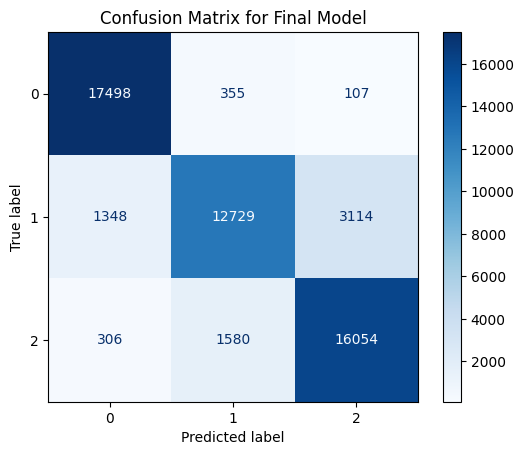


Model saved as final_mlp_model.keras
Scaler saved as scaler.pkl
Label Encoder saved as label_encoder.pkl


In [25]:
df = pd.read_csv('/Users/khim/Downloads/ready_for_running/Dataset/features/nsr_af_chf_015.csv')
X = df.drop(columns=['Label']).values
y = df['Label'].values

results = perform_final_training(
    X=X,
    y=y,
    epochs=50,
    batch_size=64,
    learning_rate=0.001
)